In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Comparison between RNA circuits and classical, activation / repression circuits

RNA circuits can only bind to each other. Does this mean that all RNAs are essentially repressing each other indirectly? 

# Imports

In [13]:
import networkx as nx
import numpy as np
import jax 
import jax.numpy as jnp 
import matplotlib.pyplot as plt

In [14]:
seed = 0
rng = jax.random.PRNGKey(seed)

n_nodes = 5
n_circuits = int(1e2)
i_in = 0
i_out = -1
w = jax.random.normal(rng, (n_circuits, n_nodes, n_nodes))
y00 = jax.random.uniform(rng, (n_circuits, n_nodes, 1))


# Paper on Robust Perfect Adaptation

https://link.springer.com/protocol/10.1007/978-1-0716-3008-2_1#Fig8

In [15]:

m_ij = jnp.delete(w, i_in, axis=1)  # delete row i_in
m_ij = jnp.delete(m_ij, i_out, axis=2)  # delete column i_out

det_w = jax.vmap(jnp.linalg.det)(w)
det_m_ij = jax.vmap(jnp.linalg.det)(m_ij)

idxs_rpa = np.where((np.abs(det_m_ij / det_w) < 1e-5) & (det_w != 0))[0]

print('Circuit topologies with perfect robust adaptation\n', w[idxs_rpa])

Circuit topologies with perfect robust adaptation
 []


# Simulate

In [16]:
from functools import partial
import diffrax as dfx
from synbio_morpher.utils.modelling.solvers import make_stepsize_controller
from evoscaper.utils.simulation import simulate_steady_states

def de_sim(t, x, args, rates):
    return (x * rates).sum(axis=0)


def sim(y0, t0, t1, dt0, rates, solver, saveat, max_steps, stepsize_controller):
    
    term = dfx.ODETerm(partial(de_sim, rates=rates))
    sol = dfx.diffeqsolve(term, solver,
                          t0=t0, t1=t1, dt0=dt0,
                          y0=y0.squeeze(),
                          saveat=saveat, max_steps=max_steps,
                          stepsize_controller=stepsize_controller)
    
    return sol.ts, sol.ys

In [21]:
dt0 = 0.01
dt1_factor = 5
t0 = 0
t1 = 10
save_steps = 100
max_steps = int(1e8)
stepsize_controller = 'adaptive'
threshold = 1e-5
total_time = None
signal_target = 2
signal_onehot = np.zeros(n_nodes)
signal_onehot[i_in] = 1

rate_max = w.max()
dt0 = np.min([1 / (5 * rate_max), dt0])
dt1 = dt1_factor * dt0
total_time = t1 - t0 if total_time is None else total_time

sim_func = jax.jit(jax.vmap(partial(sim,
                            t0=t0,
                            t1=t1,
                            dt0=dt0,
                            solver=dfx.Tsit5(),
                            saveat=dfx.SaveAt(
                                ts=np.linspace(t0, t1, save_steps)),
                            max_steps=max_steps,
                            stepsize_controller=make_stepsize_controller(
                                t0=t0, t1=t1, dt0=dt0, dt1=dt1, choice=stepsize_controller),
                            )))

y00s, ts0 = simulate_steady_states(y0=y00, total_time=total_time, sim_func=sim_func, t0=t0,
                                   t1=t1, threshold=threshold, disable_logging=False, rates=w)
# y0 = np.array(y00s[:, -1, :]).reshape(y00.shape)

# # Signal
# y0m = y0 * ((signal_onehot == 0) * 1) + y00 * signal_target * signal_onehot
# ys, ts = simulate_steady_states(t0=y0m, total_time=total_time, sim_func=sim_func, t0=t0,
#                                 t1=t1, threshold=threshold, disable_logging=False, rates=w)
# ys = np.concatenate([y0m, ys.squeeze()[:, :-1, :]], axis=1)

Done:  0:00:00.970618


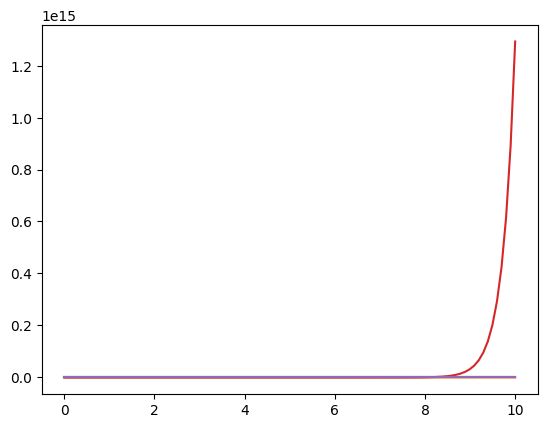

In [22]:
plt.plot(ts0, y00s[0, :, :])